# Лабораторная работа № 4

Бровкин Аким Алексеевич, ИСУ 465282, группа J3110

Воробьёв Андрей Павлович, ИСУ 465440, группа J3111

Шакина Анна Сергеевна, ИСУ 396675, группа J3111

# Генерация и визуализация данных

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm, t, f_oneway
from itertools import combinations

np.random.seed(645)
plt.rcParams['figure.figsize'] = (8, 5)

## Генерация выборок

Рассмотрим два набора данных с различными характеристиками:
* Первый набор: Три группы с близкими математическими ожиданиями (0, 0.05, 0.01)
* Второй набор: Три группы с существенно различающимися математическими ожиданиями (0, 2, 4)

Обе выборки имеют одинаковую дисперсию 1 и размер каждой группы 50.

In [11]:
n_sub = 50
close = [0, 0.05, 0.01]
far = [0, 2, 4]
sigma = 1

# Выборка с близкими математическими ожиданиями
groups_close = [np.random.normal(loc=m, scale=sigma, size=n_sub) for m in close]

# Выборка с отличающимися математическими ожиданиями
groups_far = [np.random.normal(loc=m, scale=sigma, size=n_sub) for m in far]

## Визуализация KDE

Далее мы визуализируем ядерную оценку плотности наших распределений

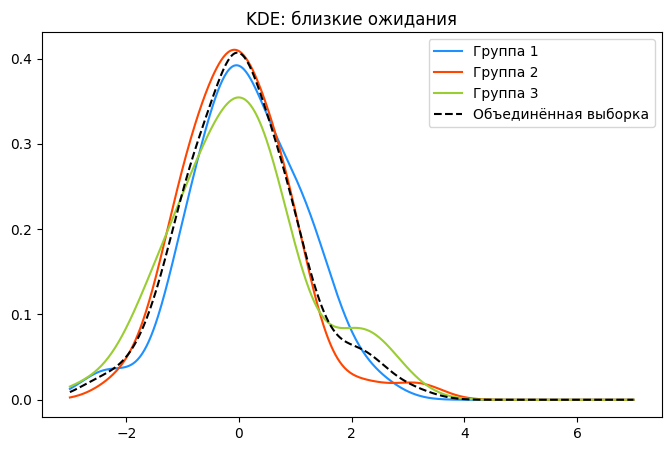

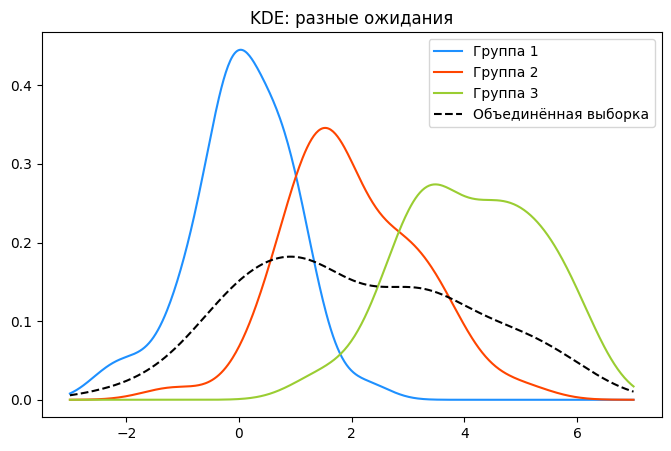

In [12]:
def plot_kde(groups, title):
    x_grid = np.linspace(-3, 7, 500)
    plt.figure()
    colors = ["dodgerblue", "orangered", "yellowgreen"]
    for idx, data in enumerate(groups):
        kde = gaussian_kde(data)
        plt.plot(x_grid, kde(x_grid), label=f'Группа {idx + 1}', color=colors[idx])

    # KDE объединённой выборки
    all_data = np.hstack(groups)
    kde_all = gaussian_kde(all_data)
    plt.plot(x_grid, kde_all(x_grid), label='Объединённая выборка', linestyle='--', color='black')
    plt.title(title)
    plt.legend()
    plt.show()


plot_kde(groups_close, 'KDE: близкие ожидания')
plot_kde(groups_far, 'KDE: разные ожидания')

Из первого графика заметно, что средние значения групп близки друг к другу, и KDE каждой группы сильно перекрываются и образуют почти единую кривую. Из второго графика видно, что группы имеют заметно разные средние (0, 2, 4), и KDE групп чётко разделены, пики распределений расположены на разных уровнях и не перекрываются.

# Парные тесты

Нулевая гипотеза ($H_0$): Средняя разность пар $x$ и $y$ равна нулю (d_mean = 0). <br/>
Альтернативная гипотеза ($H_1$): Средняя разность не равна нулю (d_mean != 0).

## Парный тест при известных дисперсиях

In [13]:
def paired_test_known_sigma(x, y, sigma_1, sigma_2, alpha=0.05):
    d = x - y
    d_mean = np.mean(d)
    n = len(d)
    se = np.sqrt((sigma_1 ** 2) / n + (sigma_2 ** 2) / n)
    z = d_mean / se
    p_value = 2 * (1 - norm.cdf(abs(z)))
    critical = norm.ppf(1 - alpha / 2)

    return z, p_value, critical

## Парный тест при неизвестных, но равных дисперсиях

In [14]:
def paired_test_unknown_equal_sigma(x, y, alpha=0.05):
    d = x - y
    d_mean = np.mean(d)
    s = np.std(d, ddof=1)
    n = len(d)
    se = s / np.sqrt(n)
    t_stat = d_mean / se
    df = n - 1
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))
    critical = t.ppf(1 - alpha / 2, df)

    return t_stat, p_value, critical

## Применение парных тестов ко всем парам групп

## Статистические показатели

### Z-тест

**Z-статистика**

Измеряет, насколько сильно среднее разностей $(\bar{d})$ отклоняется от нуля, используя стандартные ошибки в качестве единицы измерения. Чем больше абсолютное значение $|z|$, тем убедительнее доказательства против нулевой гипотезы.

**P-значение (Z)**

Это вероятность того, что мы получим наблюдаемое значение $z$ (или еще более экстремальное), если бы нулевая гипотеза $H_0$ была верна.

**Критическое значение (z)**

Пороговое значение для $z$. Если рассчитанная z-статистика превышает это значение, мы отвергаем нулевую гипотезу $H_0$.

---

### T-тест

**T-статистика**

Подобна z-статистике, но использует выборочное стандартное отклонение $s$ вместо известного $\sigma$. Это позволяет учесть дополнительную неопределенность, когда истинная дисперсия генеральной совокупности неизвестна.

**P-значение (t)**

Аналогично p-значению для Z-теста, но рассчитывается с использованием t-распределения, чтобы учесть дополнительную неопределенность, связанную с оценкой дисперсии по выборке.

**Критическое значение (t)**

Это критическое значение для t-статистики. Обычно оно выше, чем соответствующее критическое значение z-теста, из-за учета дополнительной неопределенности.

In [15]:
results = []
for name, groups in [('Близкие ожидания', groups_close), ('Разные ожидания', groups_far)]:
    for i, j in combinations(range(3), 2):
        x, y = groups[i], groups[j]
        z, p_z, crit_z = paired_test_known_sigma(x, y, sigma, sigma)
        t_stat, p_t, crit_t = paired_test_unknown_equal_sigma(x, y)
        results.append({
            'Выборка': name,
            'Пара групп': f'{i + 1}-{j + 1}',
            'z-статистика': round(z, 2),
            'p-value (Z)': round(p_z, 3),
            'crit (Z)': round(crit_z, 2),
            't-статистика': round(t_stat, 2),
            'p-value (t)': round(p_t, 3),
            'crit (t)': round(crit_t, 2),
        })

df = pd.DataFrame(results)
display(df.style.hide())

Выборка,Пара групп,z-статистика,p-value (Z),crit (Z),t-статистика,p-value (t),crit (t)
Близкие ожидания,1-2,0.770000,0.444000,1.960000,0.830000,0.413000,2.010000
Близкие ожидания,1-3,0.600000,0.548000,1.960000,0.550000,0.587000,2.010000
Близкие ожидания,2-3,-0.170000,0.869000,1.960000,-0.160000,0.872000,2.010000
Разные ожидания,1-2,-9.670000,0.000000,1.960000,-9.110000,0.000000,2.010000
Разные ожидания,1-3,-20.290000,0.000000,1.960000,-19.630000,0.000000,2.010000
Разные ожидания,2-3,-10.620000,0.000000,1.960000,-9.510000,0.000000,2.010000


Для выборки с близкими ожиданиями:

- Оба теста не отвергают $H_0$.

- Различия между группами статистически незначимы.

- z-тест и t-тест дают схожие результаты.

Для выборки с разными ожиданиями:

- Все p-values = 0: гипотеза $H_0$ отвергается.

- Модули статистик значительно превышают критические $(|z| > 1.96, |t| > 2.01)$.

# ANOVA

In [16]:
for name, groups in [('Близкие ожидания', groups_close), ('Разные ожидания', groups_far)]:
    f_stat, p_value = f_oneway(*groups)
    print(f'{name} ANOVA: F={f_stat:.2f}, p={p_value:.3f}')

Близкие ожидания ANOVA: F=0.30, p=0.740
Разные ожидания ANOVA: F=171.61, p=0.000


## Анализ результатов ANOVA

### Близкие ожидания
- F = 0.3, p = 0.7
- p > 0.05: нет статистически значимых различий между группами
- Низкая F-статистика подтверждает близость средних значений

### Разные ожидания
- F = 171.61, p = 0.000
- p < 0.05: есть статистически значимые различия
- Высокая F-статистика указывает на существенные различия между группами

# Выводы

## Анализ распределений (KDE)

### Близкие средние
Когда средние значения близки, графики плотности распределения сильно перекрываются, образуя единое, непрерывное распределение. Визуально центры групп не различимы.

### Различные средние
Если средние значения отличаются, на графике видно чёткое разделение групп с тремя выраженными пиками. Перекрытие между группами минимально.

## Результаты статистических тестов

### Парные сравнения

#### Близкие средние
Для близких средних p-значения для всех пар превышают 0.05, а тестовые статистики низкие. Это означает, что значимых различий между группами нет.

#### Различные средние
В случае различных средних p-значения для всех пар близки к нулю, а тестовые статистики высокие. Это свидетельствует о значительных различиях между всеми парами групп.

### ANOVA

#### Близкие средние
При близких средних значениях F = 0.3 и p = 0.7. Поскольку p > 0.05, статистически значимых различий между группами нет. Низкое значение F-статистики подтверждает схожесть средних.

#### Различные средние
Когда средние значения различаются, F = 171.61 и p = 0.000. Так как p < 0.05, это указывает на статистически значимые различия между группами. Высокое значение F-статистики подчеркивает существенные различия.

## Сравнение методов анализа

### Вычислительная эффективность
ANOVA проводит один тест для всех групп, тогда как парные тесты требуют отдельного сравнения для каждой пары. При увеличении числа групп ANOVA становится значительно эффективнее.

### Информативность
ANOVA предоставляет общую оценку различий между группами. В свою очередь, парные тесты дают детальную информацию о различиях между конкретными парами. Сочетание этих методов обеспечивает наиболее полное понимание данных.